In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [168]:
np.random.seed(42)

In [169]:
df = pd.read_csv('data.csv')
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [170]:
X = df.drop(columns=['diagnosis'])
Y = df['diagnosis']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

ss = StandardScaler()
le = LabelEncoder()

x_train = ss.fit_transform(x_train)
x_test  = ss.transform(x_test)

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [171]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [172]:
class MultiLayerPerceptron:
    def __init__(self, in_feat, out_feat, n_neurons, lr, step_fn):
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.n_neurons = n_neurons
        self.weights1 = np.random.uniform(low=-1, high=1, size=(in_feat, n_neurons))
        self.weights2 = np.random.uniform(low=-1, high=1, size=(n_neurons, out_feat))
        self.bias = np.random.uniform(low=-1, high=1, size=n_neurons+1)
        self.lr = lr
        self.step_fn = np.vectorize(step_fn)

    def __call__(self, x):
        o1 = x @ self.weights1 + self.bias[:self.n_neurons]
        o1 = self.step_fn(o1)
        o2 = o1 @ self.weights2 + self.bias[self.n_neurons:]
        return o1, self.step_fn(o2)
    
    def backward(self, y_true, y_pred, o1, x):
        final_error = y_pred * (1 - y_pred) * (y_true - y_pred)
        temp_error = np.multiply(o1, (np.ones(o1.shape) - o1)).reshape(-1, 1)
        error_weights = final_error * self.weights2
        hidden_error = np.multiply(temp_error, error_weights)
        self.weights1 += self.lr * (x.reshape(-1,1) @ hidden_error.T)
        self.weights2 += self.lr * (final_error.item() * o1.reshape(-1, 1))
        self.bias[-1] += self.lr * final_error.item()
        self.bias[:self.n_neurons] += self.lr * hidden_error.reshape(-1)

In [173]:
mlp = MultiLayerPerceptron(x_train.shape[1], 1, 24, 0.1, sigmoid)

In [174]:
def train_loop(perceptron, x_train, y_train, batch_size=1):
    if len(x_train) != len(y_train):
        raise ValueError("Length of X and Y are not equal")
    i = 0
    while i < len(x_train) - batch_size:
        x = x_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        o1, y_pred = perceptron(x)
        perceptron.backward(y, y_pred, o1, x)   
        i += batch_size     

def test_loop(perceptron, x_test, y_test):
    _, y_pred = perceptron(x_test)
    error = abs(y_test - y_pred)
    error = np.sum(error)
    return error

100%|██████████| 5000/5000 [02:03<00:00, 40.45it/s]


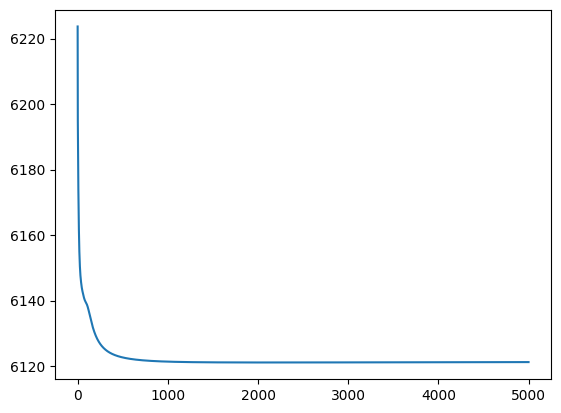

In [175]:
n_epochs = 5000
val_losses = []
for i in tqdm(range(n_epochs)):
    train_loop(mlp, x_train, y_train)
    val_loss = test_loop(mlp, x_test, y_test)
    #print(f"The error on validation data is : {val_loss}")
    val_losses.append(val_loss)

plt.plot(val_losses)